In [1]:
from dask.distributed import Client, LocalCluster
# from dask_jobqueue import SLURMCluster

cluster = LocalCluster()
# cluster = SLURMCluster(cores=12, name='test', walltime='00:30:00',
#                        job_extra=['--constraint=HSW24','--exclusive','--nodes=1'], 
#                        memory='118GB', interface='ib0'
#                       ) 
cluster.scale(12)
# # cluster.adapt(minimum=1, maximum=48)

client = Client(cluster)
# client = Client()
client

/scratch/cnt0024/hmg2840/tuchida/condapack/lib/python3.7/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Failed to start diagnostics server on port 8787. [Errno 13] Permission denied
  warnings.warn("\n" + msg)


Client Scheduler: tcp://127.0.0.1:44172 Dashboard: http://127.0.0.1:42471/status,Cluster Workers: 12 Cores: 72 Memory: 202.37 GB


In [2]:
import xarray as xr
import numpy as np
import xscale
import gsw
import os.path as op
from xgcm.grid import Grid as xgrid
from xnemogcm import open_domain_cfg, open_nemo
from xhistogram.xarray import histogram as xhist

from matplotlib.gridspec import GridSpec
import matplotlib.colors as clr
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
ddir = '/store/CT1/hmg2840/lbrodeau/eNATL60/eNATL60-BLBT02-S/'
xtra = '/store/CT1/hmg2840/lbrodeau/eNATL60/eNATL60-BLBT02X-S'
scratch = '/scratch/cnt0024/hmg2840/tuchida/temp'

In [4]:
g = 9.81
Ce = 0.01
Cp = 4e3
rhoConst = 1e3
ys,ye = (2000,2500)
xs,xe = (2300,3100)
zchunk = 4
z10 = 6

dsmask = xr.open_dataset(op.join(ddir,'../eNATL60-I/mesh_mask_eNATL60_3.6.nc'), chunks={'z':zchunk})
dsmask

<xarray.Dataset>
Dimensions:       (t: 1, x: 8354, y: 4729, z: 300)
Dimensions without coordinates: t, x, y, z
Data variables:
    nav_lon       (y, x) float32 dask.array<chunksize=(4729, 8354), meta=np.ndarray>
    nav_lat       (y, x) float32 dask.array<chunksize=(4729, 8354), meta=np.ndarray>
    nav_lev       (z) float32 dask.array<chunksize=(4,), meta=np.ndarray>
    time_counter  (t) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    tmask         (t, z, y, x) int8 dask.array<chunksize=(1, 4, 4729, 8354), meta=np.ndarray>
    umask         (t, z, y, x) int8 dask.array<chunksize=(1, 4, 4729, 8354), meta=np.ndarray>
    vmask         (t, z, y, x) int8 dask.array<chunksize=(1, 4, 4729, 8354), meta=np.ndarray>
    fmask         (t, z, y, x) int8 dask.array<chunksize=(1, 4, 4729, 8354), meta=np.ndarray>
    tmaskutil     (t, y, x) int8 dask.array<chunksize=(1, 4729, 8354), meta=np.ndarray>
    umaskutil     (t, y, x) int8 dask.array<chunksize=(1, 4729, 8354), meta=np.ndarray>
    vmaskutil     (t, y, x) int8 dask.array<chunksize=(1, 4729, 8354), meta=np.ndarray>
    fmaskutil     (t, y, x) int8 dask.array<chunksize=(1, 4729, 8354), meta=np.ndarray>
    glamt         (t, y, x) float32 dask.array<chunksize=(1, 4729, 8354), meta=np.ndarray>
    glamu         (t, y, x) float32 dask.array<chunksize=(1, 4729, 8354), meta=np.ndarray>
    glamv         (t, y, x) float32 dask.array<chunksize=(1, 4729, 8354), meta=np.ndarray>
    glamf         (t, y, x) float32 dask.array<chunksize=(1, 4729, 8354), meta=np.ndarray>
    gphit         (t, y, x) float32 dask.array<chunksize=(1, 4729, 8354), meta=np.ndarray>
    gphiu         (t, y, x) float32 dask.array<chunksize=(1, 4729, 8354), meta=np.ndarray>
    gphiv         (t, y, x) float32 dask.array<chunksize=(1, 4729, 8354), meta=np.ndarray>
    gphif         (t, y, x) float32 dask.array<chunksize=(1, 4729, 8354), meta=np.ndarray>
    e1t           (t, y, x) float64 dask.array<chunksize=(1, 4729, 8354), meta=np.ndarray>
    e1u           (t, y, x) float64 dask.array<chunksize=(1, 4729, 8354), meta=np.ndarray>
    e1v           (t, y, x) float64 dask.array<chunksize=(1, 4729, 8354), meta=np.ndarray>
    e1f           (t, y, x) float64 dask.array<chunksize=(1, 4729, 8354), meta=np.ndarray>
    e2t           (t, y, x) float64 dask.array<chunksize=(1, 4729, 8354), meta=np.ndarray>
    e2u           (t, y, x) float64 dask.array<chunksize=(1, 4729, 8354), meta=np.ndarray>
    e2v           (t, y, x) float64 dask.array<chunksize=(1, 4729, 8354), meta=np.ndarray>
    e2f           (t, y, x) float64 dask.array<chunksize=(1, 4729, 8354), meta=np.ndarray>
    ff            (t, y, x) float64 dask.array<chunksize=(1, 4729, 8354), meta=np.ndarray>
    mbathy        (t, y, x) int16 dask.array<chunksize=(1, 4729, 8354), meta=np.ndarray>
    misf          (t, y, x) int16 dask.array<chunksize=(1, 4729, 8354), meta=np.ndarray>
    isfdraft      (t, y, x) float32 dask.array<chunksize=(1, 4729, 8354), meta=np.ndarray>
    e3t_0         (t, z, y, x) float64 dask.array<chunksize=(1, 4, 4729, 8354), meta=np.ndarray>
    e3u_0         (t, z, y, x) float64 dask.array<chunksize=(1, 4, 4729, 8354), meta=np.ndarray>
    e3v_0         (t, z, y, x) float64 dask.array<chunksize=(1, 4, 4729, 8354), meta=np.ndarray>
    e3w_0         (t, z, y, x) float64 dask.array<chunksize=(1, 4, 4729, 8354), meta=np.ndarray>
    gdept_0       (t, z, y, x) float32 dask.array<chunksize=(1, 4, 4729, 8354), meta=np.ndarray>
    gdepu         (t, z, y, x) float32 dask.array<chunksize=(1, 4, 4729, 8354), meta=np.ndarray>
    gdepv         (t, z, y, x) float32 dask.array<chunksize=(1, 4, 4729, 8354), meta=np.ndarray>
    gdepw_0       (t, z, y, x) float32 dask.array<chunksize=(1, 4, 4729, 8354), meta=np.ndarray>
    gdept_1d      (t, z) float64 dask.array<chunksize=(1, 4), meta=np.ndarray>
    gdepw_1d      (t, z) float64 dask.array<chunksize=(1, 4), meta=np.ndarray>
    e3t_1d        (t, z) float64 dask.array<chunksize=(1, 4), meta=np.ndarray

In [5]:
f = xr.apply_ufunc(gsw.f, dsmask.nav_lat.sel(y=slice(ys,ye),x=slice(xs,xe)),
                  dask='parallelized', output_dtypes=['float',])
f

<xarray.DataArray 'nav_lat' (y: 500, x: 800)>
dask.array<f, shape=(500, 800), dtype=float64, chunksize=(500, 800), chunktype=numpy.ndarray>
Dimensions without coordinates: y, x

In [6]:
At = (dsmask.e1t * dsmask.e2t)[0].sel(y=slice(ys,ye),x=slice(xs,xe))
Au = (dsmask.e1u * dsmask.e2u)[0].sel(y=slice(ys,ye),x=slice(xs,xe))
Av = (dsmask.e1v * dsmask.e2v)[0].sel(y=slice(ys,ye),x=slice(xs,xe))
A = (dsmask.e1u * dsmask.e2v)[0].sel(y=slice(ys,ye),x=slice(xs,xe))
# e1u = dsmask.e1u[0].sel(y=slice(ys,ye),x=slice(xs,xe))
# e2u = dsmask.e2u[0].sel(y=slice(ys,ye),x=slice(xs,xe))
# e1v = dsmask.e1v[0].sel(y=slice(ys,ye),x=slice(xs,xe))
# e2v = dsmask.e2v[0].sel(y=slice(ys,ye),x=slice(xs,xe))
e2t = dsmask.e2t[0].sel(y=slice(ys,ye),x=slice(xs,xe))
e1t = dsmask.e1t[0].sel(y=slice(ys,ye),x=slice(xs,xe))
e2v = dsmask.e2v[0].sel(y=slice(ys,ye),x=slice(xs,xe))
e1u = dsmask.e1u[0].sel(y=slice(ys,ye),x=slice(xs,xe))
e2u = dsmask.e2u[0].sel(y=slice(ys,ye),x=slice(xs,xe))
e1v = dsmask.e1v[0].sel(y=slice(ys,ye),x=slice(xs,xe))
e3t = dsmask.e3t_1d[0]
e3w = dsmask.e3w_1d[0]

In [7]:
dsT = xr.open_dataset(op.join(xtra,'00788401-00842400/eNATL60-BLBT02X_1h_20100101_20100125_gridT_20100101-20100101.nc'),
                      chunks={'deptht':zchunk}
                     ).sel(deptht=slice(None,810))
dsS = xr.open_dataset(op.join(xtra,'00788401-00842400/eNATL60-BLBT02X_1h_20100101_20100125_gridS_20100101-20100101.nc'),
                      chunks={'deptht':zchunk}
                     ).sel(deptht=slice(None,810))
dsW = xr.open_dataset(op.join(xtra,'00788401-00842400/eNATL60-BLBT02X_1h_20100101_20100125_gridW_20100101-20100101.nc'),
                      chunks={'depthw':zchunk}
                     ).sel(depthw=slice(None,810))

#         if i == days[0,0]:
maskT = dsmask.tmask[0].sel(y=slice(ys,ye),x=slice(xs,xe)
                           ).isel(z=slice(None,len(dsT.deptht)))

CT01 = dsT.votemper[-1].sel(y=slice(ys,ye),x=slice(xs,xe)
                         ).where(xr.DataArray(maskT.data, dims=['deptht','y','x']
                                             ) != 0.)
SA01 = dsS.vosaline[-1].sel(y=slice(ys,ye),x=slice(xs,xe)
                         ).where(xr.DataArray(maskT.data, dims=['deptht','y','x']
                                             ) != 0.)
rho01 = xr.apply_ufunc(gsw.sigma0, SA01, CT01, dask='parallelized', output_dtypes=[float,]) + 1e3
p = xr.apply_ufunc(gsw.p_from_z, -dsT.deptht, dsmask.nav_lat.sel(y=slice(ys,ye),x=slice(xs,xe)),
                  dask='parallelized', output_dtypes=['float',])
N2, pN2 = gsw.Nsquared(SA01, CT01, p, dsmask.nav_lat.sel(y=slice(ys,ye),x=slice(xs,xe)))
N2 = xr.DataArray(N2, dims=['depthw','y','x'], coords={'depthw':dsW.depthw[1:].data})

nMLD = z10 + np.abs((rho01.isel(deptht=slice(z10,None))
                     - rho01.isel(deptht=z10)
                    )-0.03).argmin(dim='deptht').compute()
MLD01 = (xr.ones_like(rho01) * rho01.deptht
        )[{'deptht':nMLD}]
# N01 = np.sqrt((N2*xr.DataArray(e3w.data[1:len(N2.depthw)+1],dims='depthw')).where(N2.depthw < MLD01).sum('depthw') * MLD01**-1)
N01 = (np.sqrt(N2)*xr.DataArray(e3w.data[1:len(N2.depthw)+1],dims='depthw')).where(N2.depthw <= MLD01).sum('depthw') * MLD01**-1

lam01 = (N01*MLD01*f**-1).compute()
lam01

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:45542 remote=tcp://127.0.0.1:44172>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:45548 remote=tcp://127.0.0.1:44172>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:45550 remote=tcp://127.0.0.1:44172>
/scratch/cnt0024/hmg2840/tuchida/condapack/lib/python3.7/site-packages/xarray/core/computation.py:601: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


<xarray.DataArray (y: 500, x: 800)>
array([[1304.78411403, 1253.76342316, 1176.80936593, ...,  773.1926796 ,
         737.82473963,  924.84636924],
       [1307.15242418, 1137.14260259, 1289.26781647, ...,  531.87032755,
         504.13541234,  780.64671311],
       [1237.72823114, 1203.69378743, 1155.53922045, ...,  402.1053511 ,
         386.83223634,  606.38082273],
       ...,
       [ 743.53491252,  822.52982902,  850.65379169, ...,  801.0324776 ,
         725.23992851,  685.8241678 ],
       [ 835.25237306,  882.97297307,  820.56617372, ...,  727.98411918,
         621.57321625,  515.40248655],
       [ 904.49669677,  900.70962052,  926.22642495, ...,  670.40604784,
         554.874415  ,  818.16366896]])
Coordinates:
    deptht        (y, x) float64 86.15 97.26 109.0 115.2 ... 127.9 127.9 134.6
    nav_lat       (y, x) float32 36.69535 36.695553 ... 43.21733 43.217693
    nav_lon       (y, x) float32 -59.623344 -59.606667 ... -46.464603 -46.447792
    time_counter  datetime64[ns] 2010-01-01T23:30:00
Dimensions without coordinates: y, x

In [8]:
dsT = xr.open_dataset(op.join(xtra,'00896401-00950400/eNATL60-BLBT02X_1h_20100220_20100316_gridT_20100315-20100315.nc'),
                      chunks={'deptht':zchunk}
                     ).sel(deptht=slice(None,810))
dsS = xr.open_dataset(op.join(xtra,'00896401-00950400/eNATL60-BLBT02X_1h_20100220_20100316_gridS_20100315-20100315.nc'),
                      chunks={'deptht':zchunk}
                     ).sel(deptht=slice(None,810))
dsW = xr.open_dataset(op.join(xtra,'00896401-00950400/eNATL60-BLBT02X_1h_20100220_20100316_gridW_20100315-20100315.nc'),
                      chunks={'depthw':zchunk}
                     ).sel(depthw=slice(None,810))

#         if i == days[0,0]:
maskT = dsmask.tmask[0].sel(y=slice(ys,ye),x=slice(xs,xe)
                           ).isel(z=slice(None,len(dsT.deptht)))

CT03 = dsT.votemper[-1].sel(y=slice(ys,ye),x=slice(xs,xe)
                         ).where(xr.DataArray(maskT.data, dims=['deptht','y','x']
                                             ) != 0.)
SA03 = dsS.vosaline[-1].sel(y=slice(ys,ye),x=slice(xs,xe)
                         ).where(xr.DataArray(maskT.data, dims=['deptht','y','x']
                                             ) != 0.)
rho03 = xr.apply_ufunc(gsw.sigma0, SA03, CT03, dask='parallelized', output_dtypes=[float,]) + 1e3
p = xr.apply_ufunc(gsw.p_from_z, -dsT.deptht, dsmask.nav_lat.sel(y=slice(ys,ye),x=slice(xs,xe)),
                  dask='parallelized', output_dtypes=['float',])
N2, pN2 = gsw.Nsquared(SA03, CT03, p, dsmask.nav_lat.sel(y=slice(ys,ye),x=slice(xs,xe)))
N2 = xr.DataArray(N2, dims=['depthw','y','x'], coords={'depthw':dsW.depthw[1:].data})

nMLD = z10 + np.abs((rho03.isel(deptht=slice(z10,None))
                     - rho03.isel(deptht=z10)
                    )-0.03).argmin(dim='deptht').compute()
MLD03 = (xr.ones_like(rho03) * rho03.deptht
        )[{'deptht':nMLD}]
# N03 = np.sqrt((N2*xr.DataArray(e3w[1:len(N2.depthw)+1].data,dims='depthw')).where(N2.depthw<MLD03).sum('depthw') * MLD03**-1)
N03 = (np.sqrt(N2)*xr.DataArray(e3w.data[1:len(N2.depthw)+1],dims='depthw')).where(N2.depthw <= MLD03).sum('depthw') * MLD03**-1

lam03 = (N03*MLD03*f**-1).compute()
lam03

/scratch/cnt0024/hmg2840/tuchida/condapack/lib/python3.7/site-packages/xarray/core/computation.py:601: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


<xarray.DataArray (y: 500, x: 800)>
array([[2193.39814814, 2227.34493486, 2252.88822751, ..., 1608.00850367,
        1545.79580703, 1446.60724733],
       [2261.26346708, 2380.23881372, 2522.72882269, ..., 1397.59125025,
        1380.74300503, 1330.05250376],
       [2401.54339231, 2627.85658455, 2839.86986469, ..., 1203.20815389,
        1226.43077542, 1220.17876973],
       ...,
       [ 750.22312508,  760.37632354,  984.91636645, ..., 1316.80735098,
        1549.01918891, 1544.59570197],
       [ 757.72344849,  756.40378784,  931.98875255, ..., 1561.61634726,
        1549.7564329 , 1539.40318539],
       [ 773.29529719,  766.33132012,  838.27575811, ..., 1602.74234818,
        1580.27158176, 1514.44874542]])
Coordinates:
    deptht        (y, x) float64 364.6 364.6 364.6 375.6 ... 201.8 201.8 201.8
    nav_lat       (y, x) float32 36.69535 36.695553 ... 43.21733 43.217693
    nav_lon       (y, x) float32 -59.623344 -59.606667 ... -46.464603 -46.447792
    time_counter  datetime64[ns] 2010-03-15T23:30:00
Dimensions without coordinates: y, x

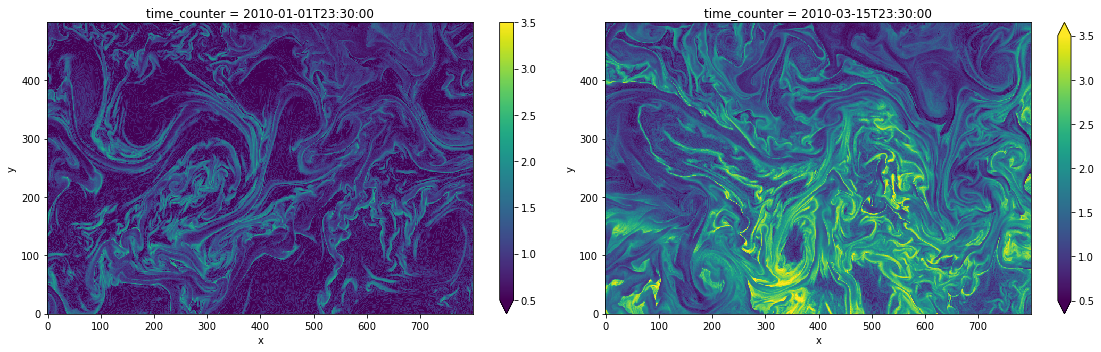

In [10]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
fig.set_tight_layout(True)
(lam01*1e-3).plot(ax=ax1, vmax=3.5e0, vmin=.5)
(lam03*1e-3).plot(ax=ax2, vmax=3.5e0, vmin=.5)

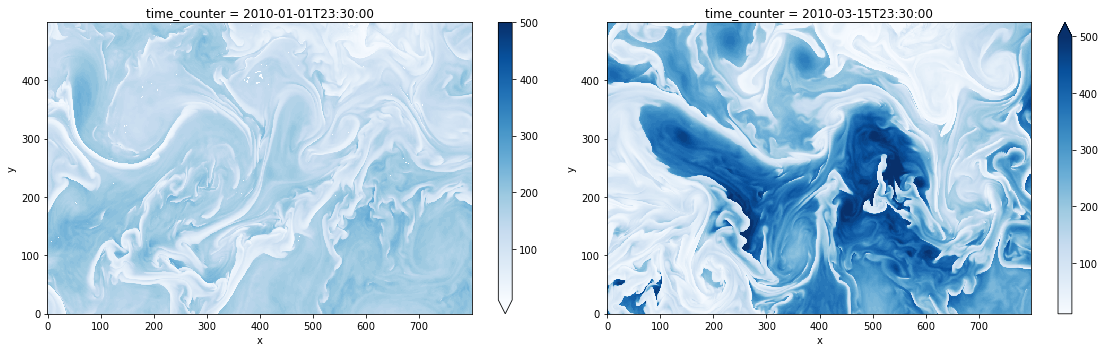

In [24]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
fig.set_tight_layout(True)
(MLD01).plot(ax=ax1, vmax=5e2, vmin=1e1, cmap='Blues')
(MLD03).plot(ax=ax2, vmax=5e2, vmin=1e1, cmap='Blues')

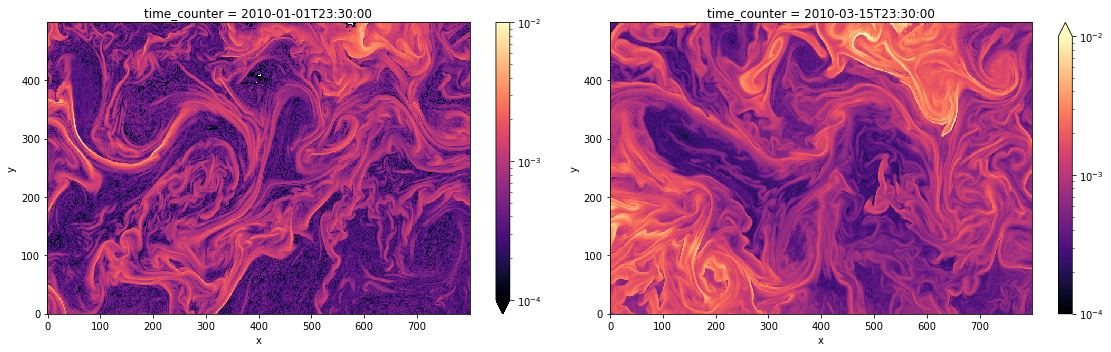

In [28]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
fig.set_tight_layout(True)
(N01).plot(ax=ax1, norm=clr.LogNorm(vmax=1e-2, vmin=1e-4), cmap='magma')
(N03).plot(ax=ax2, norm=clr.LogNorm(vmax=1e-2, vmin=1e-4), cmap='magma')